# Percent Signal Change

### Module importieren

In [38]:
import numpy as np
import pandas as pd

from nilearn import plotting, image, input_data
from nistats import first_level_model, reporting, regression

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

sns.set_context('talk')

### Design laden

In [2]:
df = pd.read_csv('../data/sub-01_task-imagery_run-02_events.tsv',sep='\t')
df = df.rename(columns={'trial_domain':'trial_type'})
df = df[df.loc[:,'trial_type']=='SPRACHE']

In [3]:
df

,onset,duration,trial_type,trial_subdomain,trial_content
2,60,30,SPRACHE,Sprechen,Lebensmittel
6,180,30,SPRACHE,Schreiben,Tiere
10,300,30,SPRACHE,Sprechen,Vornamen
16,480,30,SPRACHE,Schreiben,Staedte


### fMRT Daten laden

In [4]:
fmri_img = '../data/sub-01_task-imagery_run-02_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'
fmri_img = image.smooth_img(fmri_img,fwhm=8)

/opt/miniconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/opt/miniconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:600: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(axes, collections.Sequence):


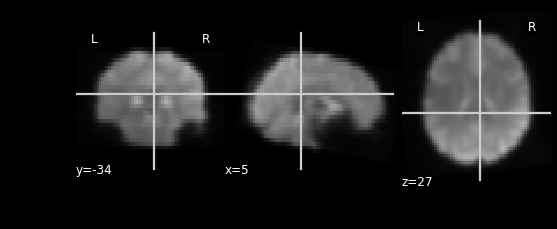

In [5]:
plotting.plot_anat(image.mean_img(fmri_img));

### Modell erstellen

In [6]:
# CAVE: diese Einstellungen sind nicht gut, aber simpel für echte fMRT-Auswertung die Defaults benutzen!
fmri_glm = first_level_model.FirstLevelModel(t_r=3,
                                             hrf_model='spm',
                                             noise_model='ols',
                                             drift_model=None,
                                             standardize=False,
                                             signal_scaling=False
                                            )

In [ ]:
fmri_glm = fmri_glm.fit(fmri_img, df)

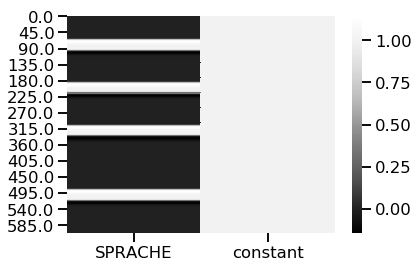

In [8]:
design_matrix = fmri_glm.design_matrices_[-1]
sns.heatmap(design_matrix,cmap='Greys_r');

### Direkt ein effect size image berechnen

#### Kontrast definieren

In [ ]:
sprache = np.array([1,0])
reporting.plot_contrast_matrix(sprache, design_matrix=design_matrix);

#### Berechnung druchführen

In [10]:
eff_img = fmri_glm.compute_contrast(sprache,
                                     output_type='effect_size')

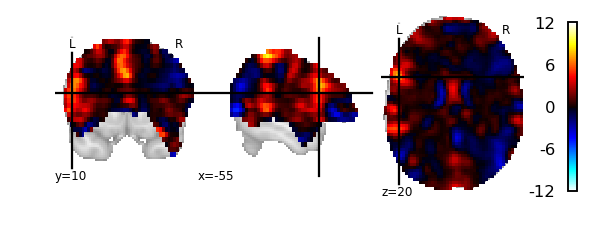

In [11]:
plotting.plot_stat_map(eff_img,cut_coords=(-55,10,20));

#### Daten extrahieren

In [12]:
masker = input_data.NiftiMasker(mask_img=fmri_glm.masker_.mask_img_).fit()

In [13]:
eff_data = masker.transform(eff_img)[-1]

### Die betas händisch berechnen

In [14]:
brain_data = masker.transform(fmri_img)

In [15]:
my_model = regression.OLSModel(design_matrix)
my_results = my_model.fit(brain_data)

In [16]:
betas = my_results.theta

In [17]:
betas.shape

(2, 34439)

In [18]:
con_data = (betas.T*sprache).sum(axis=1)

In [19]:
con_img = masker.inverse_transform(con_data)

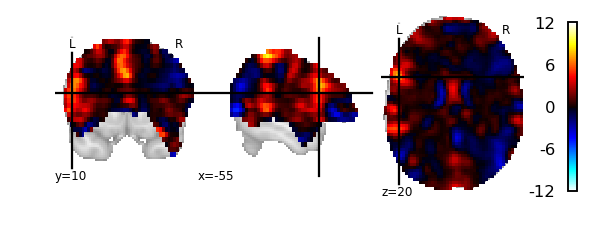

In [20]:
plotting.plot_stat_map(con_img,cut_coords=(-55,10,20));

### Vergleich der beiden Versionen

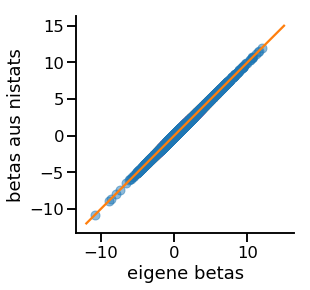

In [21]:
fig,ax = plt.subplots(1,1)
ax.plot(con_data,eff_data,'o',alpha=0.5)
plt.plot([-12,15],[-12,15])
ax.set_aspect(1)
sns.despine()

plt.xlabel('eigene betas')
plt.ylabel('betas aus nistats')
plt.show()

In [22]:
np.corrcoef(con_data,eff_data)[-1][0]

0.9999999999999999

### Aus der händischen Version den Percent Signal Change berechnen

Die Formel lautet (vgl. [mindhive.mit.edu/node/86](mindhive.mit.edu/node/86)):

    ${pcs = (value/baseline*100) - 100 }$

```
z.B. (805/800*100)-100
```

Beziehungsweise

    ${pcs = differenz_zur_baseline/baseline*100}$

```
z.B. 5/800*100
```

In [40]:
from nistats.first_level_model import mean_scaling

In [48]:
import inspect
print(inspect.getsource(mean_scaling))

def mean_scaling(Y, axis=0):
    """Scaling of the data to have percent of baseline change along the
    specified axis

    Parameters
    ----------
    Y : array of shape (n_time_points, n_voxels)
       The input data.

    Returns
    -------
    Y : array of shape (n_time_points, n_voxels),
       The data after mean-scaling, de-meaning and multiplication by 100.

    mean : array of shape (n_voxels,)
        The data mean.

    """
    mean = Y.mean(axis=axis)
    if (mean == 0).any():
        warn('Mean values of 0 observed.'
             'The data have probably been centered.'
             'Scaling might not work as expected')
    mean = np.maximum(mean, 1)
    Y = 100 * (Y / mean - 1)
    return Y, mean



Effekt wie oben:

In [23]:
con_data = (betas.T*sprache).sum(axis=1)

Baseline Datengetrieben aus dem Mittelwert jedes Voxels:

In [24]:
baseline_data = brain_data.mean(axis=0)

PSC Formel:

In [25]:
psc_data = con_data / baseline_data * 100

Als Hirnbild:

In [26]:
psc_img = masker.inverse_transform(psc_data)

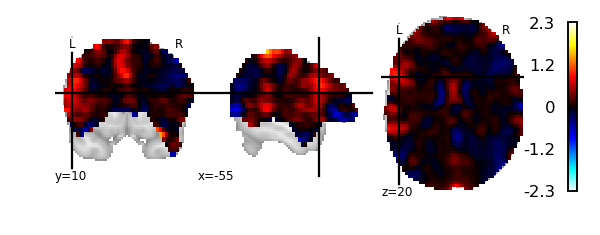

In [27]:
plotting.plot_stat_map(psc_img,cut_coords=(-55,10,20));

### Automatisch mit nistats

In [28]:
fmri_glm = first_level_model.FirstLevelModel(t_r=3,
                                             hrf_model='spm',
                                             noise_model='ols',
                                             drift_model=None,
                                             standardize=False,
                                             signal_scaling=0 # compute percent signal change (time dimension)
                                            )
fmri_glm = fmri_glm.fit(fmri_img, df)

In [29]:
eff_psc_img = fmri_glm.compute_contrast(sprache,output_type='effect_size')

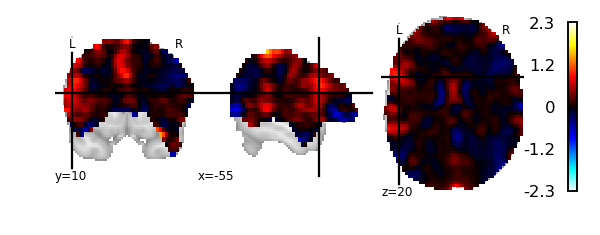

In [30]:
plotting.plot_stat_map(eff_psc_img,cut_coords=(-55,10,20));

In [31]:
eff_psc_data = fmri_glm.masker_.transform(eff_psc_img)[-1]

### Vergleich

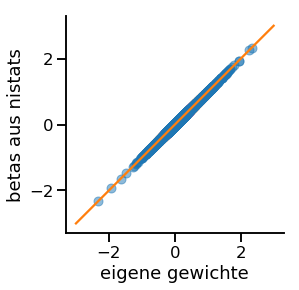

In [32]:
fig,ax = plt.subplots(1,1)
ax.plot(psc_data,eff_psc_data,'o',alpha=0.5)
ax.plot([-3,3],[-3,3])
ax.set_aspect(1)
sns.despine()

plt.xlabel('eigene gewichte')
plt.ylabel('betas aus nistats')
plt.show()

In [33]:
np.corrcoef(psc_data,eff_psc_data)[-1][0]

0.9999999999976543

### Wie verhält sich der PSC zu den Rohdaten?

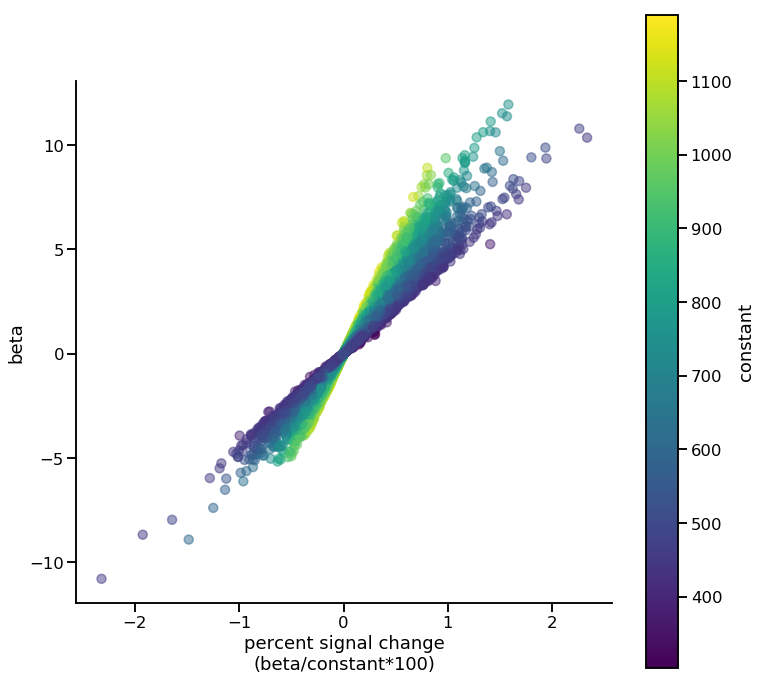

In [34]:
# colored scatterplot adapted from https://www.robotswillkillusall.org/posts/mpl-scatterplot-colorbar.html

cmap = matplotlib.cm.get_cmap('viridis')
normalize = matplotlib.colors.Normalize(vmin=min(baseline_data), vmax=max(baseline_data))
colors = [cmap(normalize(value)) for value in baseline_data]

fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(psc_data, con_data, color=colors,alpha=0.5)
ax.set_aspect(.2)

ax.set_xlabel('percent signal change\n(beta/constant*100)')
ax.set_ylabel('beta')

# Optionally add a colorbar
cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)
plt.ylabel('constant')

sns.despine()
plt.show()

Fazit: Voxel die ein hohes Signal haben (z.B. CSF, Regionen die besonders günstig in der Kopfspule liegen), werden durch Berechnung des PSC stärker zu null hin regularisiert. Wenn man davon ausgeht, dass Regionen mit höherer Baseline auch höhere Betas haben, wäre das vielleicht eine sinnvolle Art der Datenskalierung. Es scheint aber - über alle Gewebearten hinweg - keinen solchen Zusammenhang zu geben. Insgesamt sieht es eher so aus, dass Regionen mit hoher Konstante eher kleine Betas haben.

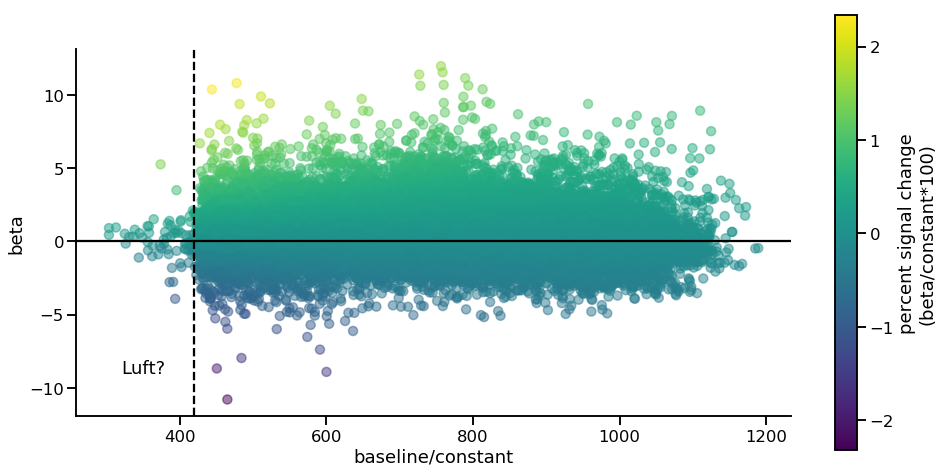

In [39]:
# colored scatterplot adapted from https://www.robotswillkillusall.org/posts/mpl-scatterplot-colorbar.html

cmap = matplotlib.cm.get_cmap('viridis')
normalize = matplotlib.colors.Normalize(vmin=min(psc_data), vmax=max(psc_data))
colors = [cmap(normalize(value)) for value in psc_data]

fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(baseline_data, con_data, color=colors,alpha=0.5)
ax.set_aspect(20)

ax.set_xlabel('baseline/constant')
ax.set_ylabel('beta')

ax.axhline(0,color='k')
ax.axvline(420,linestyle='--',color='k')
ax.annotate(s='Luft?',xy=(320,-9))

# Optionally add a colorbar
cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)
plt.ylabel('percent signal change\n(beta/constant*100)')

sns.despine()
plt.show()

#### Wie inhomogen ist die Signalintensität in den fMRT-Bildern?

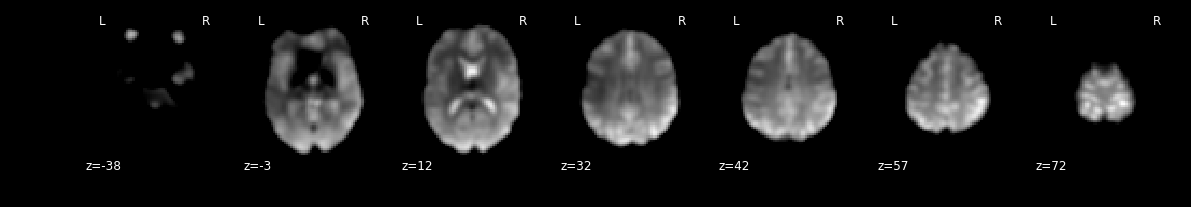

In [36]:
plotting.plot_anat(image.mean_img(fmri_img),vmin=420,vmax=1200,display_mode='z');

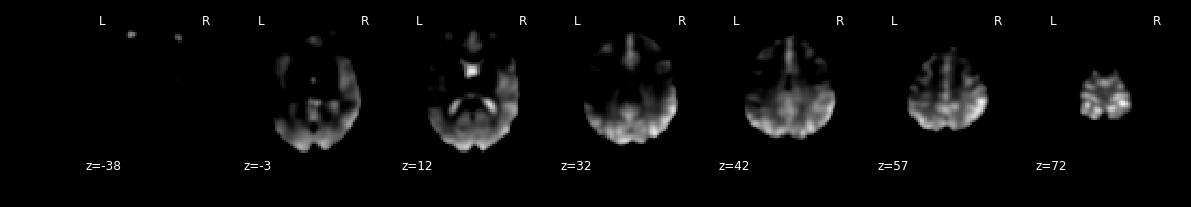

In [37]:
plotting.plot_anat(image.mean_img(fmri_img),vmin=700,vmax=1200,display_mode='z');